# Testing pipeline for the WASP-74 transit on 15 July 2017
#### The notebook also assumes that you have raw data stored in a directory called 20170715/ (which is the same name of the directory in which the data is stored on tycho, anyways). It will first compute darks and flats, then calibrate all the data (and store the calibrated files in a directory called calibrated/). Next, it will extract and store spectra. Stored spectra are retrieved and integrated across the spectral axis to produce white light curves, and the transit in the target white light curve is fit using the batman package. At the end of the day, we get a fitted light curve, and the final printed output is the unbinned RMS.

#### The reason for saving calibrated data in another directory is so that one can test different calibration schemes without having to re-calibrate data (which takes a while).

#### While this notebook is currently specific to WASP-74, I hope I have made the framework general enough to extend the testing pipeline to other transits in the near future.

#### TODO: Parellelize calibration and extraction

### This first block is the "options block." Here, you will find all of the necessary imports as well as the majority of the important options and switches for testing, arranged roughly in order of most to least used.

In [42]:
#the test_name set below will set the directories into which
#the calibration, image, and dump files are written
test_name = 'flat_test_1/'
raw_dir = '20170715/'

#flags for whether you want to run different calibration steps or not
make_darks_flats = False
calibrate_all = False
extract_all = True
plot_white_light_curves = True
fit_transit = True

#different options for spectral extraction
bp_correct_during_extraction = True      #correct bad pix only in cutouts; a bit faster overall
bkg_sub = True                           #do you want background subtraction? probably
extraction_method = 'optimal_extraction' #weightedSum was the other one, though no longer used
measured_angle = 13.43                   #setting to None allows angle to vary as a free parameter in fit
order = 1                                #what order traces are you extracting?
fractional_fit_type = 'gaussian'         #'gaussian', 'cubic', 'spline' or None

#different options for transit fitting
sigma_val = 3                            #number of sigmas for sigma-clipping in transit fit
prior_on = 1                             #optional: put prior on transit center time
dt_prior = 0.0                           #guess on offset from predicted tranist time 
dt_err_prior = 0.05                      #error on transit time (make this tiny to fix transit time in fits)

#starting and ending image numbers to be used for the darks, flats, and science images. also bkg img number
master_dark_start = 1071
master_dark_end = 1080
dark_for_flat_start = 2
dark_for_flat_end = 21
master_flat_start = 52
master_flat_end = 62
science_start = 304
science_end = 1070
background = 297

#the approximate positions of the traces on each image
order1_pos = [[1397,631],[714,220],[1439,1251],
                     [1973,1486]]                #approx radius is 28 pixels
order2_pos = [[1313,963],[628,552],[1356,1576],[1890,1816],
                     [1158,310]]                 #approx radius is 50 pixels

### The next block is the "bookkeeping block." We'll run the necessary import statements, check if necessary directories exist, set up some more extraction options, and write a helper function to write filenames with the WIRC convention (wirc####.fits).

In [43]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import wirc_drp.wirc_object as wo
from wirc_drp.utils import calibration
from astropy.io import fits
from pathlib import Path
from scipy.signal import medfilt
from scipy import optimize
from scipy import linalg as lg
import batman
import math
import warnings
import os
import pickle

def imgname(number, direc):
    """Given the image number and directory, constructs the image filename with the
    correct number of 0s."""
    num = str(number)
    num_zeros = 4 - len(num)
    return direc + 'wirc' + '0'*num_zeros + num + '.fits'

calib_dir = 'calibrated_' + test_name
dump_dir = 'dump_files_' + test_name
img_dir = 'image_files_' + test_name
Path(calib_dir).mkdir(exist_ok = True)
Path(dump_dir).mkdir(exist_ok = True)
Path(img_dir).mkdir(exist_ok = True)


#for convenience, these will be the final names for the dark, flat, bp, and hp maps. will also set background
flat = raw_dir + "wirc" + '0'*(4 - len(str(master_flat_end))) + str(master_flat_end) + "_master_flat.fits"
dark = raw_dir + "wirc" + '0'*(4 - len(str(master_dark_end))) + str(master_dark_end) + "_master_dark.fits"
bp = raw_dir + "wirc" + '0'*(4 - len(str(master_flat_end))) + str(master_flat_end) + "_bp_map.fits"            
hp = raw_dir + "wirc" + '0'*(4 - len(str(master_dark_end))) + str(master_dark_end) + "_hp_map.fits"            
bkg = imgname(background, raw_dir)

#setting more things for spectral extraction
if order == 1:
    order_in = np.array(order1_pos)
    cutout_size = 40
if order == 2:
    order_in = np.array(order2_pos)
    cutout_size = 60    

n_sources = order_in.shape[0]
n_images = science_end - science_start + 1

### First, we will make the master darks and flats.

In [44]:
if make_darks_flats:
    #first, we construct the list of files used for making each dark/flat
    master_dark_list = [imgname(i, raw_dir) for i in \
                        range(master_dark_start, master_dark_end + 1)]
    dark_for_flat_list = [imgname(i, raw_dir) for i in \
                        range(dark_for_flat_start, dark_for_flat_end + 1)]
    master_flat_list = [imgname(i, raw_dir) for i in \
                        range(master_flat_start, master_flat_end + 1)]

    #then, we make the darks and flats. simple!
    dark_for_flat, bp_name = calibration.masterDark(dark_for_flat_list)
    science_dark, bp_name = calibration.masterDark(master_dark_list)
    science_flat, bp_name = calibration.masterFlat(master_flat_list,
                                            dark_for_flat, verbose = True)

### Now, we will calibrate all of our science data.

In [45]:
if calibrate_all:
    for i in range(science_start, science_end + 1):
        if bkg_sub:
            raw_data = wo.wirc_data(raw_filename = imgname(i, raw_dir), flat_fn = flat, dark_fn = dark, 
                                    bp_fn = bp, hp_fn = hp, bkg_fn = bkg)
        else:
            raw_data = wo.wirc_data(raw_filename = imgname(i, raw_dir), flat_fn = flat, dark_fn = dark, 
                                    bp_fn = bp, hp_fn = hp)
            
        if bp_correct_during_extraction:
            raw_data.calibrate(clean_bad_pix = False)
        else:
            raw_data.calibrate()
            
        raw_data.save_wirc_object(imgname(i, calib_dir))

### Here, we will extract and save all of our spectral data.

In [46]:
if extract_all:    
    #first, we initialize all of the relevant data storage arrays
    wl_arr = np.zeros([cutout_size*2+1, n_sources, n_images])
    spec_arr = np.zeros([cutout_size*2+1, n_sources, n_images])
    spec_err_arr = np.zeros([cutout_size*2+1, n_sources, n_images])
    angle_arr = np.zeros([n_sources, n_images])
    bjd_arr = np.zeros(n_images)
    
    #now, extract from all the images
    for j in range(n_images):
        n_img = j + science_start
        name = imgname(n_img, calib_dir)
        print('Extracting from ' + name)
        calibrated_data = wo.wirc_data(wirc_object_filename = name,verbose = False)
        #we can save the times array first
        bjd_arr[j] = calibrated_data.bjd
        for i in range(n_sources):
            #adding a source to the wirc object
            calibrated_data.source_list.append(wo.wircspec_source([order_in[i,1],order_in[i,0]],
                                                    'slitless', calibrated_data.n_sources+1))
            calibrated_data.n_sources += 1

            #get cutout for the source
            if bp_correct_during_extraction:
                calibrated_data.source_list[i].get_cutouts(calibrated_data.full_image,
                            calibrated_data.filter_name, image_DQ = calibrated_data.DQ_image,
                            cutout_size = cutout_size, flip = True)
            else:
                calibrated_data.source_list[i].get_cutouts(calibrated_data.full_image,
                            calibrated_data.filter_name, cutout_size = cutout_size, flip = True)

            #extract 1D spectrum from the source
            calibrated_data.source_list[i].extract_spectra(sub_background = True, bkg_poly_order = 0, plot = False,
                            method = extraction_method, poly_order = 1, verbose = False, trace_angle = measured_angle,
                            fractional_fit_type = fractional_fit_type, spatial_sigma = 9)
            
            #write the relevant data into our data storage arrays
            wl_arr[:,i,j]=calibrated_data.source_list[i].trace_spectra[0,0,:]
            spec_arr[:,i,j]=calibrated_data.source_list[i].trace_spectra[0,1,:]
            spec_err_arr[:,i,j]=calibrated_data.source_list[i].trace_spectra[0,2,:]
            angle_arr[i, j]=calibrated_data.source_list[i].spectra_angles[0]
    
    #save times, wl, spec_arr, and spec_err arrays
    pickle.dump(bjd_arr, open(dump_dir + 'bjd.p', 'wb'))
    pickle.dump(wl_arr, open(dump_dir + 'wl_arr_order_' + str(order) + '.p','wb'))
    pickle.dump(spec_arr, open(dump_dir + 'spec_arr_order_' + str(order) + '.p', 'wb'))
    pickle.dump(spec_err_arr, open(dump_dir + 'spec_err_arr_order_' + str(order) + '.p', 'wb'))
    pickle.dump(angle_arr, open(dump_dir + 'angle_arr_order_' + str(order) + '.p', 'wb'))


Extracting from calibrated_flat_test_1/wirc0304.fits
Extracting from calibrated_flat_test_1/wirc0305.fits
Extracting from calibrated_flat_test_1/wirc0306.fits
Extracting from calibrated_flat_test_1/wirc0307.fits


/Users/shrey/Desktop/wirc/wirc_drp/utils/spec_utils.py:887: RuntimeWarning: invalid value encountered in sqrt
  spectra_std.append(np.sqrt(spec_var))


Extracting from calibrated_flat_test_1/wirc0308.fits
Extracting from calibrated_flat_test_1/wirc0309.fits
Extracting from calibrated_flat_test_1/wirc0310.fits
Extracting from calibrated_flat_test_1/wirc0311.fits
Extracting from calibrated_flat_test_1/wirc0312.fits
Extracting from calibrated_flat_test_1/wirc0313.fits
Extracting from calibrated_flat_test_1/wirc0314.fits
Extracting from calibrated_flat_test_1/wirc0315.fits
Extracting from calibrated_flat_test_1/wirc0316.fits
Extracting from calibrated_flat_test_1/wirc0317.fits
Extracting from calibrated_flat_test_1/wirc0318.fits
Extracting from calibrated_flat_test_1/wirc0319.fits
Extracting from calibrated_flat_test_1/wirc0320.fits
Extracting from calibrated_flat_test_1/wirc0321.fits
Extracting from calibrated_flat_test_1/wirc0322.fits
Extracting from calibrated_flat_test_1/wirc0323.fits
Extracting from calibrated_flat_test_1/wirc0324.fits
Extracting from calibrated_flat_test_1/wirc0325.fits
Extracting from calibrated_flat_test_1/wirc032

Extracting from calibrated_flat_test_1/wirc0463.fits
Extracting from calibrated_flat_test_1/wirc0464.fits
Extracting from calibrated_flat_test_1/wirc0465.fits
Extracting from calibrated_flat_test_1/wirc0466.fits
Extracting from calibrated_flat_test_1/wirc0467.fits
Extracting from calibrated_flat_test_1/wirc0468.fits
Extracting from calibrated_flat_test_1/wirc0469.fits
Extracting from calibrated_flat_test_1/wirc0470.fits
Extracting from calibrated_flat_test_1/wirc0471.fits
Extracting from calibrated_flat_test_1/wirc0472.fits
Extracting from calibrated_flat_test_1/wirc0473.fits
Extracting from calibrated_flat_test_1/wirc0474.fits
Extracting from calibrated_flat_test_1/wirc0475.fits
Extracting from calibrated_flat_test_1/wirc0476.fits
Extracting from calibrated_flat_test_1/wirc0477.fits
Extracting from calibrated_flat_test_1/wirc0478.fits
Extracting from calibrated_flat_test_1/wirc0479.fits
Extracting from calibrated_flat_test_1/wirc0480.fits
Extracting from calibrated_flat_test_1/wirc048

Extracting from calibrated_flat_test_1/wirc0618.fits
Extracting from calibrated_flat_test_1/wirc0619.fits
Extracting from calibrated_flat_test_1/wirc0620.fits
Extracting from calibrated_flat_test_1/wirc0621.fits
Extracting from calibrated_flat_test_1/wirc0622.fits
Extracting from calibrated_flat_test_1/wirc0623.fits
Extracting from calibrated_flat_test_1/wirc0624.fits
Extracting from calibrated_flat_test_1/wirc0625.fits
Extracting from calibrated_flat_test_1/wirc0626.fits
Extracting from calibrated_flat_test_1/wirc0627.fits
Extracting from calibrated_flat_test_1/wirc0628.fits
Extracting from calibrated_flat_test_1/wirc0629.fits
Extracting from calibrated_flat_test_1/wirc0630.fits
Extracting from calibrated_flat_test_1/wirc0631.fits
Extracting from calibrated_flat_test_1/wirc0632.fits
Extracting from calibrated_flat_test_1/wirc0633.fits
Extracting from calibrated_flat_test_1/wirc0634.fits
Extracting from calibrated_flat_test_1/wirc0635.fits
Extracting from calibrated_flat_test_1/wirc063

Extracting from calibrated_flat_test_1/wirc0773.fits
Extracting from calibrated_flat_test_1/wirc0774.fits
Extracting from calibrated_flat_test_1/wirc0775.fits
Extracting from calibrated_flat_test_1/wirc0776.fits
Extracting from calibrated_flat_test_1/wirc0777.fits
Extracting from calibrated_flat_test_1/wirc0778.fits
Extracting from calibrated_flat_test_1/wirc0779.fits
Extracting from calibrated_flat_test_1/wirc0780.fits
Extracting from calibrated_flat_test_1/wirc0781.fits
Extracting from calibrated_flat_test_1/wirc0782.fits
Extracting from calibrated_flat_test_1/wirc0783.fits
Extracting from calibrated_flat_test_1/wirc0784.fits
Extracting from calibrated_flat_test_1/wirc0785.fits
Extracting from calibrated_flat_test_1/wirc0786.fits
Extracting from calibrated_flat_test_1/wirc0787.fits
Extracting from calibrated_flat_test_1/wirc0788.fits
Extracting from calibrated_flat_test_1/wirc0789.fits
Extracting from calibrated_flat_test_1/wirc0790.fits
Extracting from calibrated_flat_test_1/wirc079

Extracting from calibrated_flat_test_1/wirc0928.fits
Extracting from calibrated_flat_test_1/wirc0929.fits
Extracting from calibrated_flat_test_1/wirc0930.fits
Extracting from calibrated_flat_test_1/wirc0931.fits
Extracting from calibrated_flat_test_1/wirc0932.fits
Extracting from calibrated_flat_test_1/wirc0933.fits
Extracting from calibrated_flat_test_1/wirc0934.fits
Extracting from calibrated_flat_test_1/wirc0935.fits
Extracting from calibrated_flat_test_1/wirc0936.fits
Extracting from calibrated_flat_test_1/wirc0937.fits
Extracting from calibrated_flat_test_1/wirc0938.fits
Extracting from calibrated_flat_test_1/wirc0939.fits
Extracting from calibrated_flat_test_1/wirc0940.fits
Extracting from calibrated_flat_test_1/wirc0941.fits
Extracting from calibrated_flat_test_1/wirc0942.fits
Extracting from calibrated_flat_test_1/wirc0943.fits
Extracting from calibrated_flat_test_1/wirc0944.fits
Extracting from calibrated_flat_test_1/wirc0945.fits
Extracting from calibrated_flat_test_1/wirc094

### Now, we will prepare the transit data for lightcurve fitting. If requested, the white light curves will also be plotted.

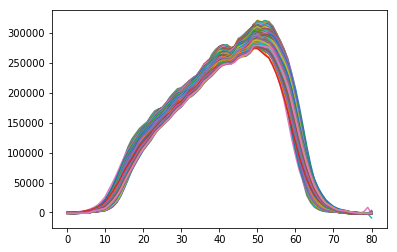

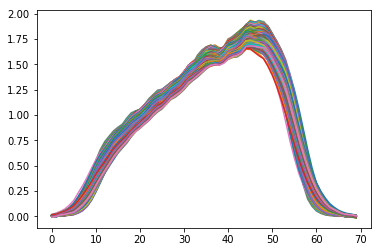

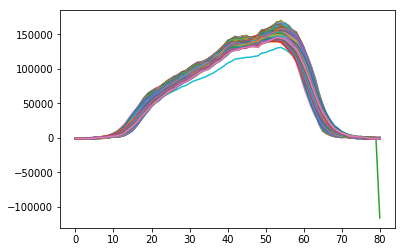

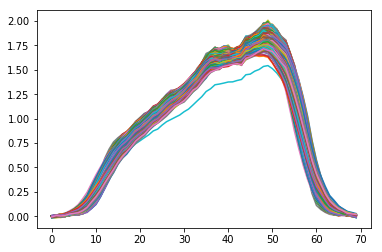

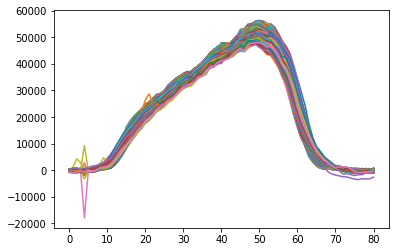

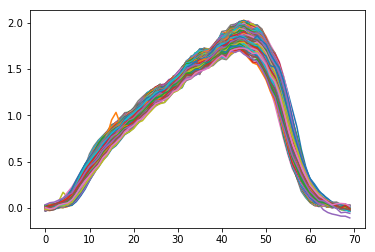

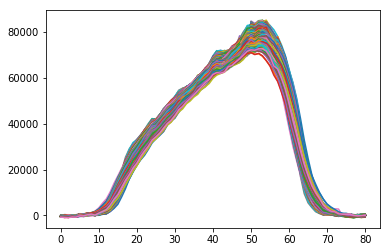

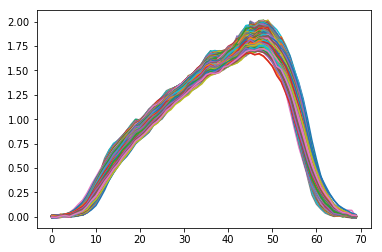

% data trimmed by outlier rejection algorithm: 0.5215123859191656
npoints after trimming: 763


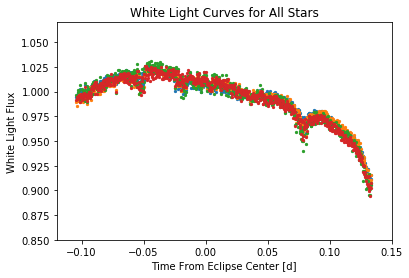

In [47]:
if fit_transit:
    #load necessary data
    spec_arr = pickle.load(open('dump_files_' + test_name + 'spec_arr_order_' + str(order) + '.p', 'rb'))
    bjd_arr = pickle.load(open('dump_files_' + test_name + 'bjd.p', 'rb'))

    #rewrite times in terms of transit center time
    t0 = 2456506.8918       #data from Hellier et al. 2015
    period = 2.137750
    nt = np.floor((bjd_arr[0] - t0)/period) + 1
    tc = t0 + period*nt
    time = bjd_arr - tc

    #summing along spectral axis to get white light curves
    white_light = np.zeros([n_sources,n_images])
    
    for i in range(n_sources):
        lims = [5,75]
        plt.plot(spec_arr[:,i,:])
        plt.show()
        plt.plot(spec_arr[lims[0]:lims[1],i,:]/np.median(spec_arr[lims[0]:lims[1],i,:]))
        plt.show()
        white_light[i,:] = np.sum(spec_arr[lims[0]:lims[1],i,:],axis=0)
        white_light[i,:] = white_light[i,:]/np.median(white_light[i,:])
    
    if plot_white_light_curves:
        for i in range(n_sources):
            plt.scatter(time, white_light[i,:], s=20, marker='.')
        plt.axis([-0.12, 0.15, 0.85, 1.07])
        plt.xlabel('Time From Eclipse Center [d]')
        plt.ylabel('White Light Flux')
        plt.title('White Light Curves for All Stars')
        plt.savefig(img_dir+'white_light_curve')
    
    #getting ready to do outlier rejection via sigma clipping
    flux = white_light[0,:]                             #target star
    img_arr = np.transpose(white_light[1:n_sources,:])  #comparison stars
    avg_comparison = np.mean(white_light[1:n_sources,:],axis=0) #average comparison star
    norm_flux = white_light[0,:]/avg_comparison         #mean-normalized target star
    old_size = norm_flux.size


    #using a moving median sigma clipping algorithm to reject outliers
    for i in range(3):
        fsize = 20                                        #size of the filter
        mflux = medfilt(norm_flux, fsize*2+1)             #median filter (pads edges with zeros)
        mflux[:fsize] = np.median(norm_flux[:2*fsize])    #filling padded region with zeros
        mflux[-fsize:] = np.median(norm_flux[-2*fsize:])  #filling padded region with zeros
        sdev = np.std(norm_flux - mflux)                  #difference flux by moving median
        ind = np.where(np.absolute(norm_flux - mflux) <=  \
                       sigma_val*sdev)                    #indices of outliers to sigma_clip
        norm_flux = norm_flux[ind]                        #discard outliers
        time = time[ind]                                  #discard outliers
        flux = flux[ind]                                  #discard outliers
        img_arr = img_arr[ind,:][0]                       #discard outliers

    print('% data trimmed by outlier rejection algorithm:', 100*(old_size - flux.size)/old_size)
    print('npoints after trimming:', flux.size)

    #re-doing median normalization
    flux /= np.median(flux)                               
    for i in range(img_arr.shape[1]): 
        img_arr[:,i] /= np.median(img_arr[:,i])
    #preliminary matrix math (Moore-Penrose pseudoinverse) for OLS fitting
    model1 = lg.inv(np.transpose(img_arr).dot(img_arr))
    model2 = model1.dot(np.transpose(img_arr))
    img_linreg = model2

### In the next block we set up our batman TransitModel object.

In [48]:
if fit_transit:
    #initial guess for transit fit (Hellier et al. 2015)
    IN = 79.81  
    RP_RS = np.sqrt(0.00961)
    b = 0.860
    a_RS = b/np.cos(IN*np.pi/180)

    #create TransitParams object for batman
    trparams = batman.TransitParams()
    trparams.t0 = 0.                    #time of inferior conjunction
    trparams.per = period               #orbital period
    trparams.rp = RP_RS                 #planet-star radius ratio
    trparams.a = a_RS                   #semi-major axis (in units of stellar radii)
    trparams.inc = IN                   #orbital inclination (in degrees)
    trparams.ecc = 0.                   #orbital eccentricity
    trparams.w = 90.                    #longitude of periastron (degrees)
    trparams.u = [0.0897,0.3588]        #limb-darkening coefficients
    #note for limb-darkening: 5990 K, log(g)=4.39, z=0.39. Coeff are for 6000 K, 4.5
    trparams.limb_dark = "quadratic"    #limb-darkening function

    init_error = np.std(flux[10:20])    #rough estimate of new RMS
    
    param0 = np.array([RP_RS, dt_prior, 0, np.log10(init_error)])
    var_names = ['RP_RS', 'dt', 'lin time', 'log(sigma)']
    m = batman.TransitModel(trparams, time)

In [49]:
if fit_transit:
    def eclipse_model_linreg(A, model, times, fluxes, compars, compar_linreg): 
        trparams.rp = A[0]                         #planet-star radius ratio
        trparams.t0 = A[1]                         #center of transit time
        
        transit_fit = model.light_curve(trparams)  #making transit model
        
        wfunct = A[2]*times                        #lin(time) detrending off normalized fluxes
        fluxes_norm = fluxes/transit_fit - wfunct
        
        coeff = compar_linreg.dot(fluxes_norm)
        dfunct = np.zeros(times.size)
        for i in range(compars.shape[1]):
            dfunct += coeff[i]*compars[:,i]
            
        return transit_fit*(wfunct + dfunct)

    def eclipse_neg_logl(A, model, times, fluxes, compars, compar_linreg,
                         prior_on, dt_prior, dt_err_prior):
        '''Calculate log likelihood for intrapixel sensitivity variations
        + transit light curve'''
        fit = eclipse_model_linreg(A, model, times, fluxes, compars, compar_linreg)
        sigma = 10**A[-1]
        cq = np.sum((fit - fluxes)**2)/sigma**2
        
        if prior_on == 1: 
            #penalizing likelihood for being far from dt_prior
            cq = cq + ((A[1]-dt_prior)/dt_err_prior)**2
            
        logL = -0.5*cq - 0.5*times.size*np.log(2*np.pi*sigma**2)
        
        if A[0] < 0: #radius ratio must be positive
            logL = -1.E8
            
        if prior_on == 1:
            logL = logL - np.log(np.ma.sqrt(2.*np.pi)*dt_err_prior)
            
        return -logL

initial guess for RP_RS: 0.0980306074652
RP_RS 0.0917262206371
dt 0.000729388564527
lin time -0.0123177345567
log(sigma) -2.75934538333
RMS: 1740.43836205 ppm


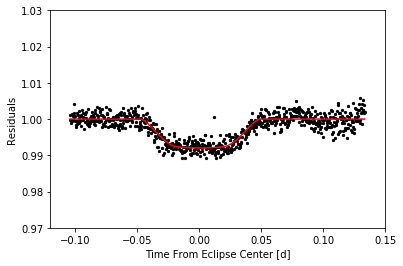

In [50]:
if fit_transit:
    #fitting the model to data. minimizing negative log likelihood == MLE.
    param = optimize.minimize(eclipse_neg_logl, param0, args=(m, time, flux, img_arr, img_linreg, prior_on, 
                                                    dt_prior, dt_err_prior), method = 'Powell', options = dict(
                                                    maxiter = 100000, maxfev = 100000, xtol = 1e-8))
    #storing the best fit
    fit = eclipse_model_linreg(param.x, m, time, flux, img_arr, img_linreg)

    #printing the best fit parameters
    print('initial guess for RP_RS:', RP_RS)
    for i in range(param0.size):
        print(var_names[i], param.x[i])
    
    #storing the best fit transit data
    trparams.rp = param.x[0] #planet-star radius ratio
    trparams.t = param.x[1]
    transit_fit = m.light_curve(trparams)

    #plotting the fitted target white light curve
    plt.scatter(time, flux, s = 20, c = 'black', marker = '.')
    plt.plot(time, fit, color = 'red')
    plt.axis([-0.12, 0.15, 0.85, 1.07])
    plt.xlabel('Time From Eclipse Center [d]')
    plt.ylabel('Relative Flux')
    plt.savefig(img_dir + 'white_light_fit')
    plt.close()
    
    #plotting the transit fit
    plt.scatter(time, flux * transit_fit / fit, s = 20, c = 'black', marker = '.')
    plt.plot(time, transit_fit, color = 'red')
    plt.axis([-0.12, 0.15, 0.97, 1.03])
    plt.xlabel('Time From Eclipse Center [d]')
    plt.ylabel('Residuals')
    plt.savefig(img_dir + 'transit_fit')

    #what's our final RMS?
    rms = np.std(flux - fit)*1e6
    print('RMS: ' + str(rms) + ' ppm')

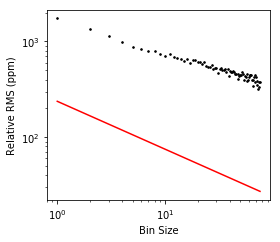

In [51]:
def plot_rootn( resid,rms_phot ):
    #makes root-N plot for a given set of residuals
    nmax=math.floor(resid.size/10) #max bin size for 10 bins
    nbin=np.array(range(nmax))+1
    rms=np.zeros(nmax)
    rms[0]=np.std(resid)
    if rms[0] < rms_phot: 
        print('WARNING: RMS LOWER THAN PHOTON NOISE LIMIT',min_rms_phot,rms[0],rms[0]/min_rms_phot)
        print('Setting photon noise limit = unbinned RMS')
        min_rms_phot=rms[0]
    for i in range(1,nmax):
        npoints=math.floor(resid.size/nbin[i])
        rr=resid[0:npoints*nbin[i]]
        binresid=rebin_factor(rr,nbin[i])
        rms[i]=np.std(binresid)
    
    #white_noise=rms[0]/np.sqrt(nbin) #pure red noise measurement
    white_noise=rms_phot/np.sqrt(nbin) #diff vs photon noise
    results=np.zeros([nbin.size,3])
    results[:,0]=nbin
    results[:,1]=rms
    results[:,2]=white_noise

    return results

#define a function to rebin array by an integer factor
def rebin_factor( a,binsize ):
    '''Rebin a vector to a new shape.  
    newshape must be a factor of a.shape'''
    newsize=np.int(a.size/binsize)
    newshape=np.zeros(newsize)
    assert len(a.shape) == len(newshape.shape)
    assert not np.sometrue(np.mod(a.shape,newshape.shape ))
    
    #binsize=np.int(a.size/newshape.size)
    for i in range(newshape.size): 
        newshape[i]=np.sum(a[i*binsize:(i+1)*binsize])/binsize
    
    return newshape

#define a function to rebin array using a fixed time interval
def rebin( ti,fi,ei,err_out,binstep,print_opt ):
    '''Calculates error-weighted average of an input vector.  Set err_out=1 to return vector of errors.'''
    ind=np.where(ti != 0)
    #print('ind',ind.shape)
    ti=np.array(ti[ind])
    fi=np.array(fi[ind])
    ei=np.array(ei[ind])
    tstart=np.ma.minimum(ti)
    nbins=math.floor((np.ma.maximum(ti)-np.ma.minimum(ti))/binstep)
    if print_opt==1:
        npoints=ti.size
        print('number of bins in plot',nbins,'points per bin',np.floor(npoints/nbins))
    binflux=np.zeros(nbins)
    for i in range(nbins):
        ind=np.array(np.where((ti >= i*binstep+tstart) & (ti < (i+1)*binstep+tstart)))
        if ind.size >= 3:
            if err_out==0:
                binflux[i]=np.sum(fi[ind]/ei[ind]**2)/np.sum(1/ei[ind]**2)
            else:
                binflux[i]=np.sqrt(1/np.sum(1/ei[ind]**2))
        #print(i,binflux[i])
    ind=np.where(binflux != 0)
    binflux=np.array(binflux[ind])
    
    return binflux

#make root-n plot
fig,axL = plt.subplots(nrows=1,ncols=1,figsize=(4,3.5),sharex='col',sharey='row') #sharex=True
fig = plt.gcf()
axL = fig.get_axes()
ri = flux - fit
rms_phot = 0.000237
#rms_phot=np.std(ri)
results=plot_rootn(ri,rms_phot)
nbin=results[:,0]
rms=results[:,1]*1.E6
white_noise=results[:,2]*1.E6
#figure out nbins = 30 minutes
dt_min=(time-time[0])*24*60
# print('RMS for '+str(dt_min[66])+' min bin (ppm)',rms[66]*1.E6)
#tmp=np.minimum(np.arange(npoints),np.absolute(dt_min-30),where=True)
#print('minimum',tmp)
plt.sca(axL[0])
plt.scatter(nbin,rms,s=10,c='black',marker='.')
plt.plot(nbin,white_noise,color='red')
#plt.axis([0,100,1.E-3,1.E-1])
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Bin Size')
plt.ylabel('Relative RMS (ppm)')
plt.draw()